In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.applications import imagenet_utils
import warnings
from tensorflow.keras.preprocessing import image
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-01-14 13:16:23.104426: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-14 13:16:23.104503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
os.chdir('../')

In [11]:
os.chdir('data/')
if os.path.isdir('train/pizza') is False:
    os.makedirs('train/pizza')
    os.makedirs('train/not_pizza')
    os.makedirs('valid/pizza')
    os.makedirs('valid/not_pizza')
    os.makedirs('test/pizza')
    os.makedirs('test/not_pizza')
    pizza = listdir('pizza/')
    not_pizza=listdir('not_pizza/')
    
    for i in random.sample(pizza, 750):
        shutil.move(f'pizza/{i}', 'train/pizza/')      
        pizza.remove(i)
    for i in random.sample(not_pizza, 750):
        shutil.move(f'not_pizza/{i}', 'train/not_pizza/')
        not_pizza.remove(i)
    for i in random.sample(pizza, 150):
        shutil.move(f'pizza/{i}', 'valid/pizza/')  
        pizza.remove(i)
    for i in random.sample(not_pizza, 150):
        shutil.move(f'not_pizza/{i}', 'valid/not_pizza/')
        not_pizza.remove(i)
    for i in random.sample(pizza, 83):
        shutil.move(f'pizza/{i}', 'test/pizza/')      
        pizza.remove(i)
    for i in random.sample(not_pizza, 83):
        shutil.move(f'not_pizza/{i}', 'test/not_pizza/')
        not_pizza.remove(i)

In [36]:
train_path='data/train'
valid_path='data/valid'
test_path='data/test'

In [37]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1500 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 166 images belonging to 2 classes.


In [48]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
imgs, labels = next(test_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

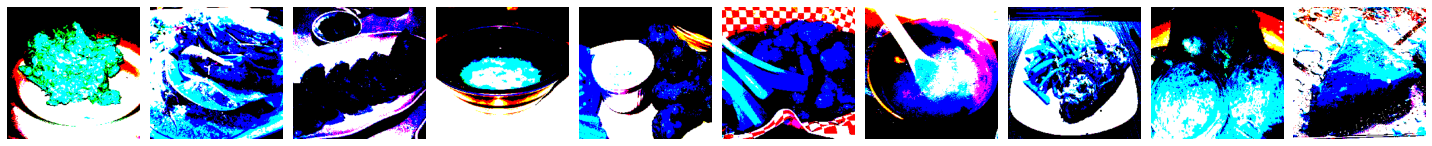

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [41]:
plotImages(imgs)
print(labels)

In [42]:
# padding = 'same' means dimensionality of images aren't reduced
model = Sequential( [
    Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),
    Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(units=2,activation='softmax')
])
# increasing number of neurons layer by layer is a common practice

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [44]:
# binary_crossentropy => activation of last layer should be sigmoid and 1 output node from model instead of 2
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [45]:
# We are not specifying y because when data is stored as a generator, the generator itself contains the actual labels
model.fit(x=train_batches,validation_data=valid_batches,epochs=15,verbose=2)

Epoch 1/15
150/150 - 55s - loss: 17.9765 - accuracy: 0.6400 - val_loss: 4.0038 - val_accuracy: 0.6800 - 55s/epoch - 365ms/step
Epoch 2/15
150/150 - 47s - loss: 2.3669 - accuracy: 0.7820 - val_loss: 3.0379 - val_accuracy: 0.6867 - 47s/epoch - 315ms/step
Epoch 3/15
150/150 - 50s - loss: 0.7205 - accuracy: 0.8773 - val_loss: 2.4966 - val_accuracy: 0.7233 - 50s/epoch - 332ms/step
Epoch 4/15
150/150 - 52s - loss: 0.1661 - accuracy: 0.9560 - val_loss: 2.7333 - val_accuracy: 0.6767 - 52s/epoch - 349ms/step
Epoch 5/15
150/150 - 48s - loss: 0.0950 - accuracy: 0.9707 - val_loss: 2.8425 - val_accuracy: 0.6800 - 48s/epoch - 321ms/step
Epoch 6/15
150/150 - 51s - loss: 0.1255 - accuracy: 0.9627 - val_loss: 2.4149 - val_accuracy: 0.7100 - 51s/epoch - 340ms/step
Epoch 7/15
150/150 - 49s - loss: 0.0195 - accuracy: 0.9953 - val_loss: 2.3247 - val_accuracy: 0.7200 - 49s/epoch - 329ms/step
Epoch 8/15
150/150 - 45s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.3222 - val_accuracy: 0.7233 - 45s/epoch - 29

# Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

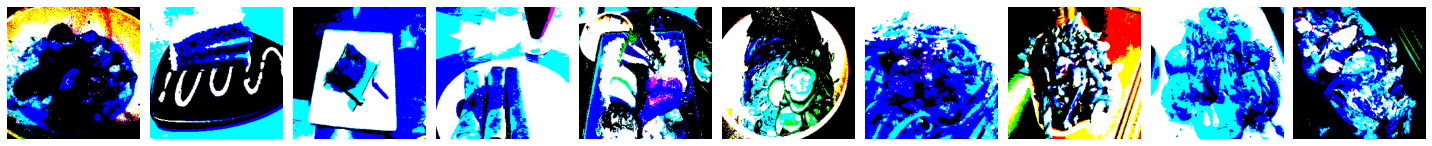

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [46]:
test_imgs, test_labels=next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [49]:
predictions=model.predict(x=test_batches,verbose=0)

In [51]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.

In [52]:
# Confusion matrix
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=1))

In [56]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [54]:
test_batches.class_indices

{'not_pizza': 0, 'pizza': 1}

In [58]:
cm

array([[63, 20],
       [24, 59]], dtype=int64)

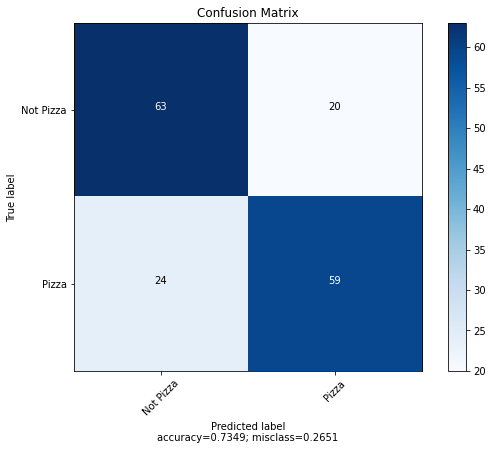

In [59]:
cm_plot_labels=['Not Pizza','Pizza']
plot_confusion_matrix(cm=cm,target_names=cm_plot_labels,title='Confusion Matrix',normalize=False)

# Build Fine-tuned VGG16 model

In [60]:
vgg16_model=keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 49s 0us/step


In [61]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [62]:
newmodel = Sequential()
# Add all layers except the last one
for layer in vgg16_model.layers[:-1]:
    newmodel.add(layer)

In [63]:
newmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [65]:
# This freezes the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of pizza/ non_pizza
for layer in newmodel.layers:
    layer.trainable = False

In [66]:
newmodel.add(Dense(units=2, activation='softmax'))

In [67]:
newmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [70]:
# Train the fine tuned VGG16 model
newmodel.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
newmodel.fit(x=train_batches,validation_data=valid_batches,epochs=5,verbose=2)

Epoch 1/5
150/150 - 345s - loss: 0.1516 - accuracy: 0.9360 - val_loss: 0.1830 - val_accuracy: 0.9233 - 345s/epoch - 2s/step
Epoch 2/5
150/150 - 352s - loss: 0.1175 - accuracy: 0.9580 - val_loss: 0.1733 - val_accuracy: 0.9300 - 352s/epoch - 2s/step
Epoch 3/5
150/150 - 361s - loss: 0.0999 - accuracy: 0.9633 - val_loss: 0.1787 - val_accuracy: 0.9300 - 361s/epoch - 2s/step
Epoch 4/5
150/150 - 351s - loss: 0.0863 - accuracy: 0.9713 - val_loss: 0.1737 - val_accuracy: 0.9267 - 351s/epoch - 2s/step
Epoch 5/5
150/150 - 349s - loss: 0.0757 - accuracy: 0.9753 - val_loss: 0.1820 - val_accuracy: 0.9200 - 349s/epoch - 2s/step


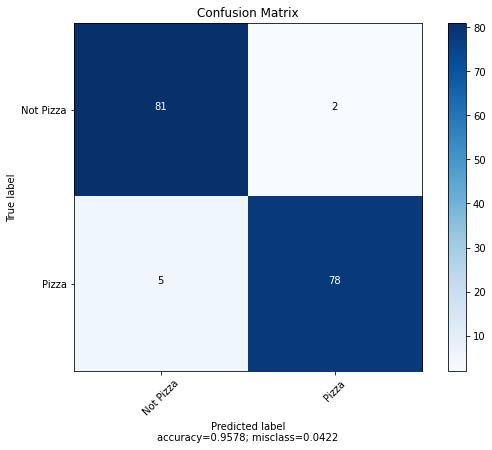

In [72]:
# Prediction
newPred=newmodel.predict(x=test_batches,verbose=0)
newCm=confusion_matrix(y_true=test_batches.classes,y_pred=np.argmax(newPred,axis=1))
newPlotLabels=['Not Pizza','Pizza']
plot_confusion_matrix(cm=newCm,target_names=newPlotLabels,title='Confusion Matrix',normalize=False)

In [73]:
import sys
sys.path.append('../')
from makeImageData import imgData

In [74]:
imgData?

In [94]:
unLabTest,lab=imgData('data/UnLabeledTest/test/',0,(224,224))

In [95]:
unLabTest.shape

(11, 224, 224, 3)

In [96]:
pred=newmodel.predict(x=unLabTest,verbose=0)

In [101]:
pred=np.argmax(pred,axis=1)

In [102]:
train_batches.class_indices

{'not_pizza': 0, 'pizza': 1}

Not Pizza


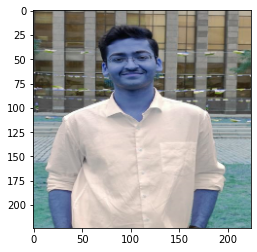

Not Pizza


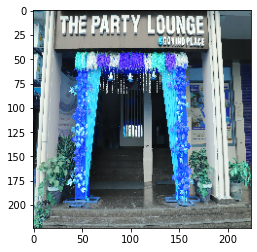

Not Pizza


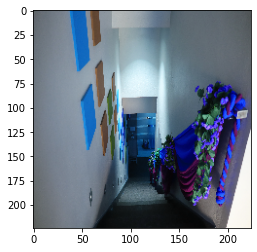

Pizza


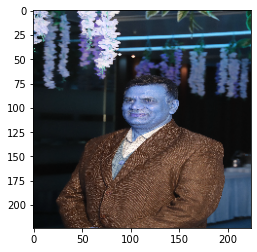

Not Pizza


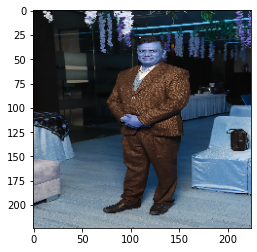

Not Pizza


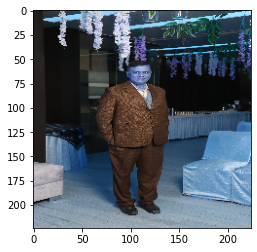

Pizza


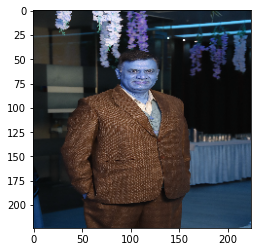

Pizza


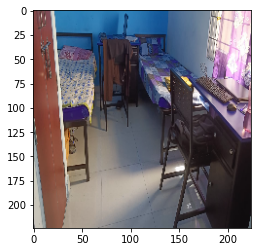

Pizza


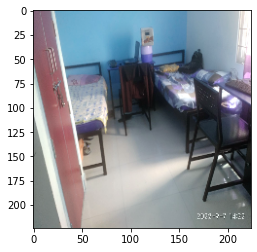

Not Pizza


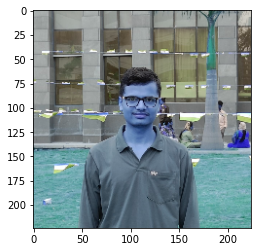

Pizza


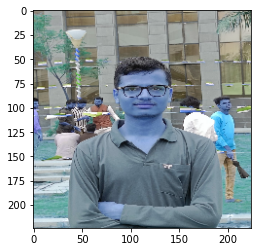

In [103]:
for i in range(11):
    plt.imshow(unLabTest[i])
    if pred[i]==0:
        print("Not Pizza")
    else:
        print("Pizza")
    plt.show()

# Mobile Net

In [3]:
mobile=keras.applications.mobilenet.MobileNet()

2023-01-14 13:16:48.237527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-14 13:16:48.237568: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-14 13:16:48.237599: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Aaryan): /proc/driver/nvidia/version does not exist
2023-01-14 13:16:48.237886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


17225924/17225924 [==============================] - 2s 0us/step


In [110]:
def prepare_image(file):
    img_path = 'data/UnLabeledTest/test/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

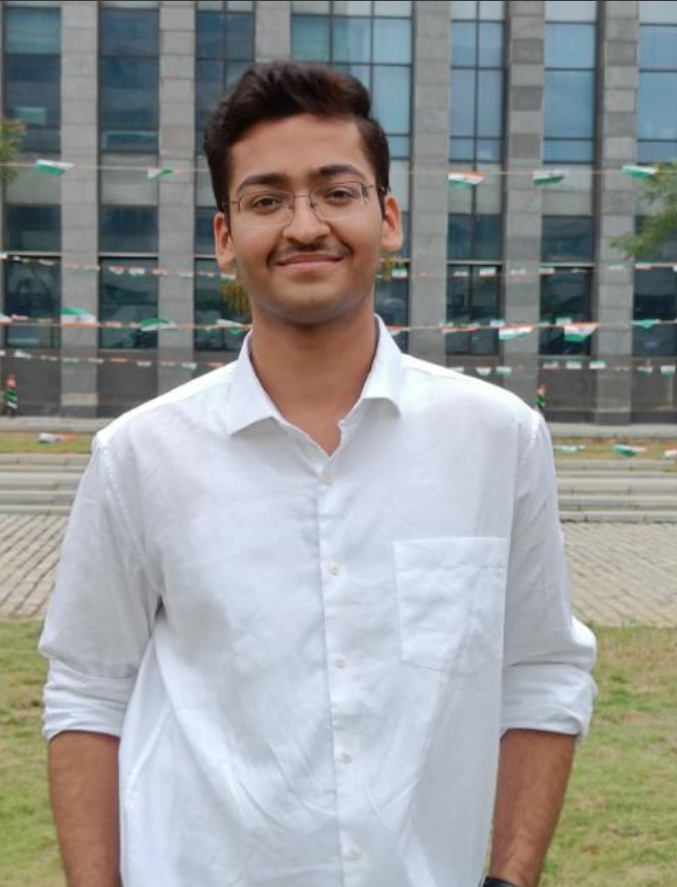

In [105]:
from IPython.display import Image
Image(filename='data/UnLabeledTest/test/abhishek.png', width=300,height=200) 

In [111]:
preprocessed_image = prepare_image('abhishek.png')
mob_predictions = mobile.predict(preprocessed_image)

1/1 [==============================] - 2s 2s/step


In [114]:
results = imagenet_utils.decode_predictions(mob_predictions)
results

35363/35363 [==============================] - 0s 0us/step


[[('n02963159', 'cardigan', 0.77811646),
  ('n04591157', 'Windsor_tie', 0.021988962),
  ('n03630383', 'lab_coat', 0.02045773),
  ('n04355933', 'sunglass', 0.010645414),
  ('n03680355', 'Loafer', 0.009191021)]]

In [4]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9